# NON-STATIONARY: Historical TC (Vortex model winds) waves generation

A historical tropical cyclone will be adquired from ibtracs-wmo database and processed with Vortex model, generated wind fields will be used to feed a SWAN-NON-STATIONARY case in order to solve waves propagation.

SWAN scenario is a demo case based on Kwajalein atoll.


## Table of Contents

* [1. Database](#db)
* [2. SWAN project](#sp)
    * [2.1. SWAN main mesh](#sp-mm)
    * [2.2. SWAN nested mesh](#sp-nm)
    * [2.3. SWAN case parameters](#sp-params)
    * [2.4. SWAN input: storm track, no waves](#sp-input)
* [3. Plot site configuration](#plot-site)
* [4. SWAN WRAP](#sw)
    * [4.1 Build cases](#sw-bc)
        * [Plot Main Mesh Input: Vortex and Grafiti maximum winds](#plot-mmi)
        * [Plot Nested Mesh Input: Vortex and Grafiti maximum winds](#plot-nmi)
    * [4.2 Run cases](#sw-rc)
        * [Plot Main Mesh Output: Hsig (time instant) and Hsig Max. (Grafiti)](#plot-mmo)
        * [Plot Nested Mesh Output: Hsig (time instant) and Hsig Max. (Grafiti)](#plot-nmo)
        * [Plot output: Control Point time series](#plot-ots)
    * [4.3 Extract output](#eo)


In [1]:

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# swan wrap module
from wswan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT
from wswan.storms import historic_track_preprocessing, historic_track_interpolation

# plotting
from wswan.plots.nonstationary import plot_project_site, plot_case_input, \
plot_case_output_grafiti, plot_case_vortex_grafiti, plot_case_output_points, \
plot_case_vortex_input, plot_case_output


##  1. Database <a name="db"></a>


In [2]:
# path data
p_data = op.abspath(op.join(os.path.abspath(''), '..', 'data'))
p_demo = op.join(p_data, 'demo', 'kwa')

# load shoreline
np_shore = np.load(op.join(p_demo, 'shore_kwa.npy'))

# load bathymetry
xds_bathy = xr.open_dataset(op.join(p_demo, 'depth_kwa.nc'))

# load storms
ibtracs = xr.open_dataset(op.join(p_demo, 'Allstorms.ibtracs_wmo.v03r10.nc'))


## 2. SWAN: Project <a name="sp"></a>


In [3]:
p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_02_demo'                 # project name

sp = SwanProject(p_proj, n_proj)

# some optional data (will be used at plotting)
sp.shore = np_shore  # project shoreline


###  2.1. SWAN main mesh <a name="sp-mm"></a>


In [4]:
# get variables from bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]
depth = xds_bathy.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
main_mesh.dg_idla = 3

# depth value (from file)
main_mesh.depth = depth

# computational grid description
res = 0.136  # (15km = 0.136º)  

main_mesh.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res),
    'myc': int((lat[-1]-lat[0])/res),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res),

}

sp.set_main_mesh(main_mesh)


### 2.2. SWAN nested mesh <a name="sp-nm"></a>


In [5]:
# lets cut inputh depth to a smaller area
xds_bathy_nest = xds_bathy.sel(
    lon = slice(165, 170),
    lat = slice(7, 10),
)

# get variables from bathymetry 
lon = xds_bathy_nest.lon.values[:]
lat = xds_bathy_nest.lat.values[:]
depth = xds_bathy_nest.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
mesh_nest = SwanMesh()

# depth grid description (input bathymetry grid)
mesh_nest.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
mesh_nest.dg_idla = 3

# depth value (from file)
mesh_nest.depth = depth

# computational grid description
res_nest = 0.04533

mesh_nest.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res_nest),
    'myc': int((lat[-1]-lat[0])/res_nest),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res_nest),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res_nest),

}

# set project nested mesh list
sp.set_nested_mesh_list([mesh_nest])


###  2.3. SWAN case parameters <a name="sp-params"></a>


In [6]:

input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',
    'set_cdcap': 2.5*10**-3,

    'coords_mode': 'SPHERICAL',
    'coords_projection': 'CCM',

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',
    
    'boundn_mode':'CLOSED',

    'wind_deltinp': '20 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '20 MIN',
    'output_deltt': '30 MIN',
    
    'output_points_x': [167.7336],
    'output_points_y': [8.66686],
    
    'output_points_spec': True,

    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        #'SETUP',  # not compatible with spherical coords
        'TRIADS',
        'DIFFRAC',
    ],

    'numerics':[
        'PROP BSBT',
    ]
}
sp.set_params(input_params)


### 2.4. SWAN input: storm track, no waves <a name="sp-input"></a>


In [7]:
# target coordinates
target = 'Kwajalein'
x0, y0 = 167.73, 8.72

# get variables from main bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]


# select & extract storm data (v3.10) --> PAKA (december 1997)
storm = ibtracs.sel(storm=5628)

# preprocess storm variables
d_vns = {
    'longitude':'lon_wmo',
    'latitude':'lat_wmo',
    'time': 'time_wmo',
    'pressure':'pres_wmo',
    'maxwinds':'wind_wmo',
}

st_time, ylat_tc, ylon_tc, ycpres, ywind, ts, categ, vmean = historic_track_preprocessing(storm, d_vns)

# computational time step 
dt_comp = 20  # min, must comply criteria: (20' if vmean < 20km/h), (10' if vmean > 20km/h)

# generate interpolated storm track  
st, time_input = historic_track_interpolation(
    st_time, ylon_tc, ylat_tc, ycpres, ywind,
    y0, x0, lat[0], lon[0], lat[-1], lon[-1],  
    ts, dt_comp, wind=ywind,
    great_circle=True
)

# [OPTIONAL] override SWAN storm case computational delta time (compute_deltc) parameter
st.attrs['override_dtcomp'] = '20 MIN'


# generate empty wave event
we = pd.DataFrame(index=time_input, columns=['hs', 't02', 'dir', 'spr', 'U10', 'V10'])
we['level'] = 0
we['tide'] = 0


##  3. Plot site configuration <a name="plot-site"></a>


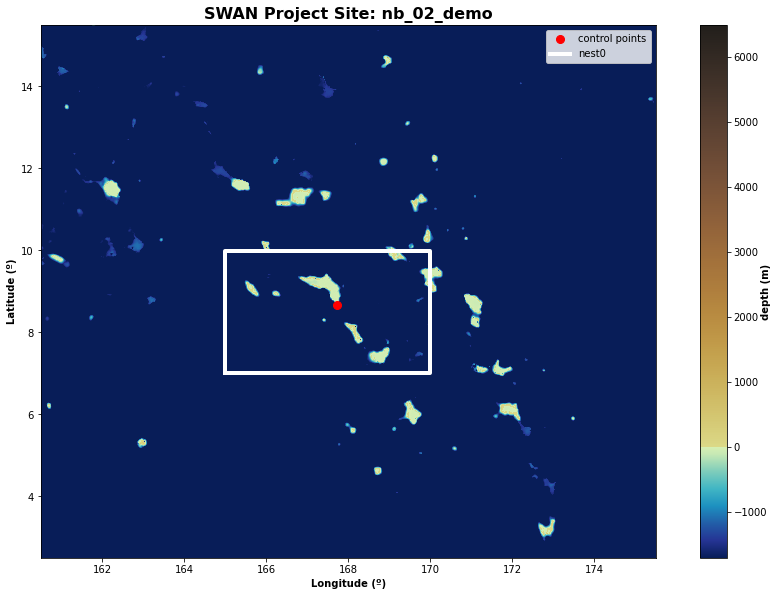

In [8]:
# plot site depth, control points, nested meshes (if any)
plot_project_site(sp, shoreline=False);


## 4. SWAN WRAP <a name="sw"></a>


In [9]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)


### 4.1. Build cases <a name="sw-bc"></a>


In [10]:
# build non-stationary cases from wave_events list and storm_tracks list
sw.build_cases([we], storm_track_list=[st], make_waves=False, make_levels=False)


CASE 0000 - compute_deltc, wind_deltinp override with storm track: 20 MIN


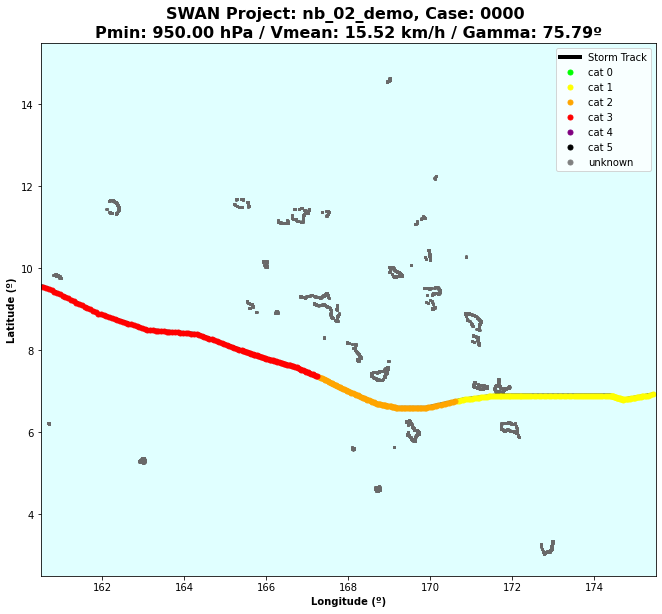

In [11]:
plot_case_input(sp, storm_track_list = [st]);


### Plot Main Mesh Input: Vortex and Grafiti maximum winds <a name="plot-mmi"></a>


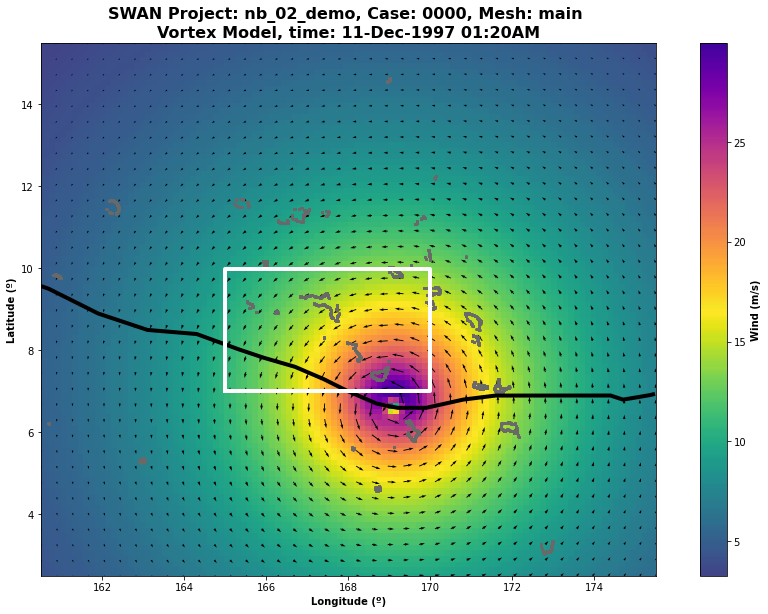

In [12]:
plot_case_vortex_input(sw, storm_track_list = [st], t_num=150, show_nested=True);


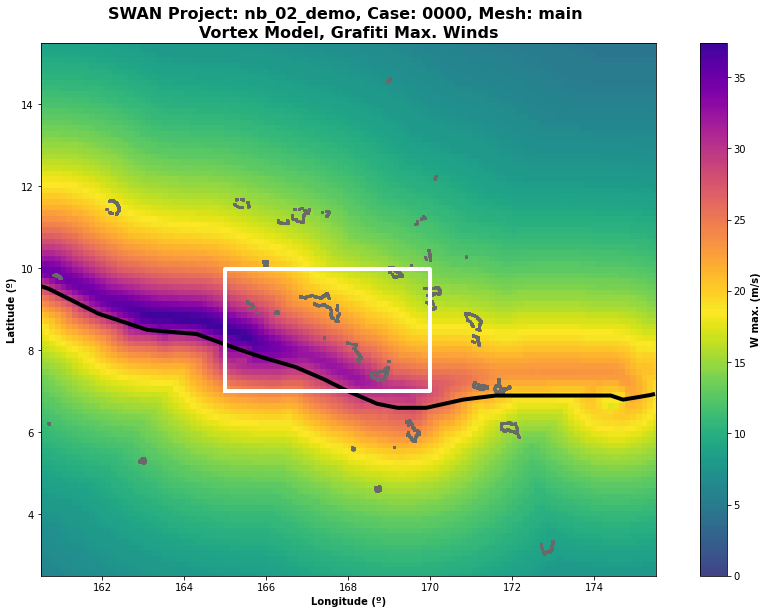

In [13]:
plot_case_vortex_grafiti(sw, storm_track_list = [st], show_nested=True);


### Plot Nested Mesh Input: Vortex and Grafiti maximum winds <a name="plot-nmi"></a>


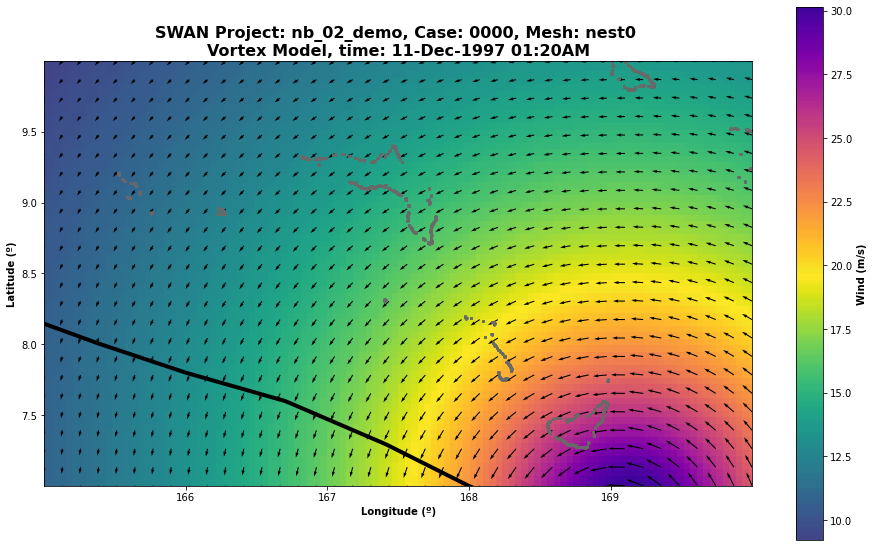

In [14]:
plot_case_vortex_input(sw, storm_track_list = [st], t_num=150, mesh=sp.mesh_nested_list[0]);


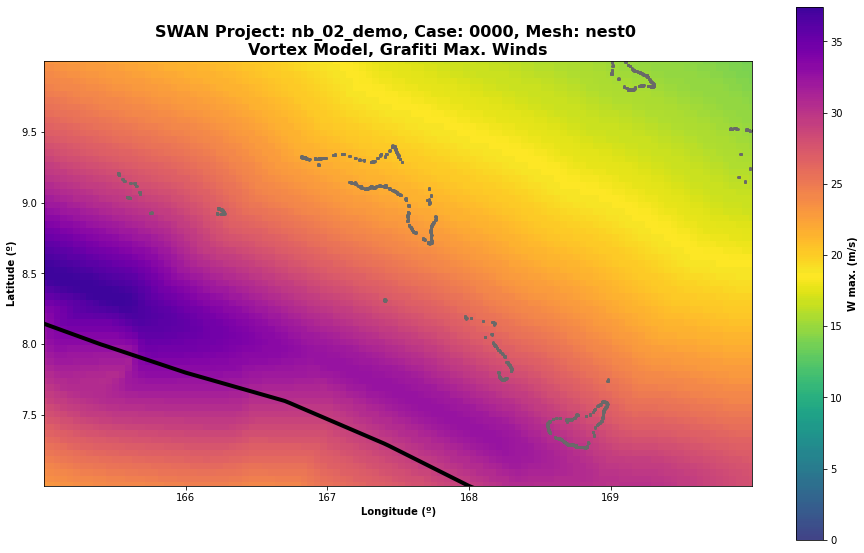

In [15]:
plot_case_vortex_grafiti(sw, storm_track_list = [st], mesh=sp.mesh_nested_list[0]);


###  4.2 Run cases <a name="sw-rc"></a>


In [16]:
sw.run_cases()


### Plot Main Mesh Output: Hsig (time instant) and Hsig Max. (Grafiti) <a name="plot-mmo"></a>


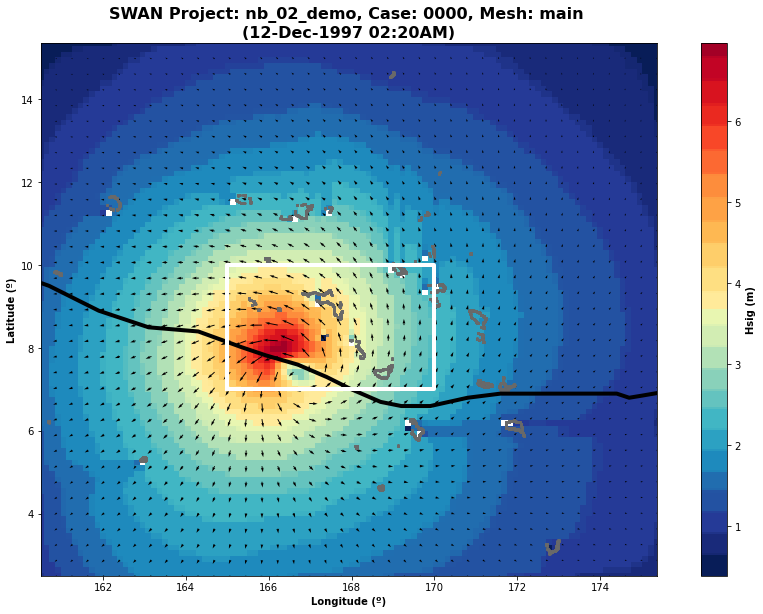

In [17]:
plot_case_output(sw, storm_track_list = [st], t_num=150, show_nested=True);


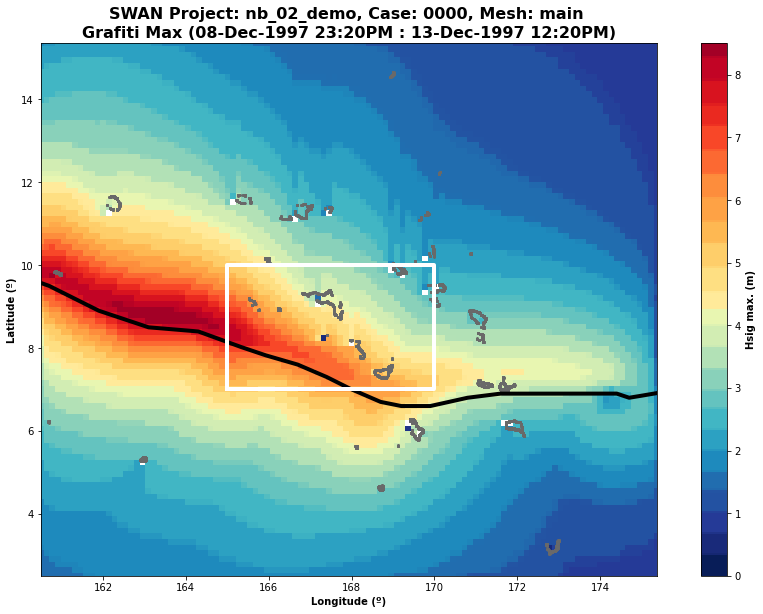

In [18]:
plot_case_output_grafiti(sw, storm_track_list = [st], show_nested=True);


### Plot Nested Mesh Output: Hsig (time instant) and Hsig Max. (Grafiti) <a name="plot-nmo"></a>


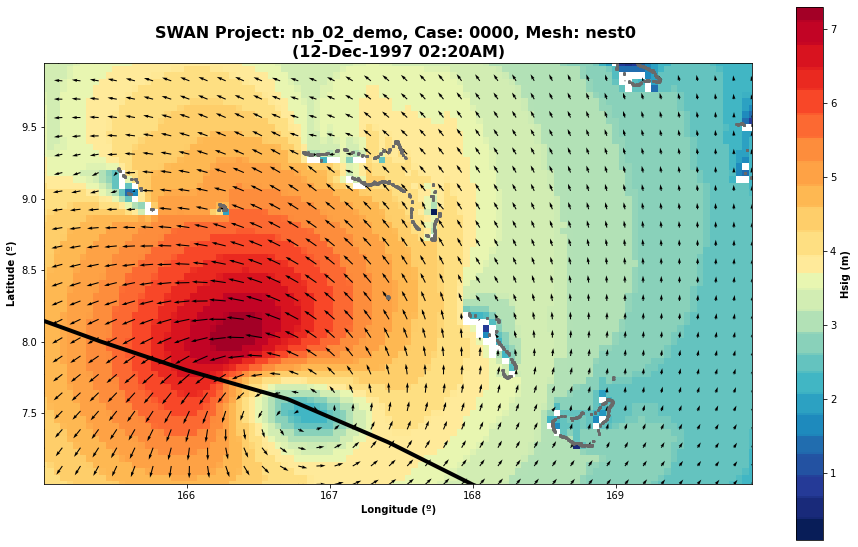

In [19]:
plot_case_output(sw, storm_track_list = [st], t_num=150, mesh=sp.mesh_nested_list[0]);


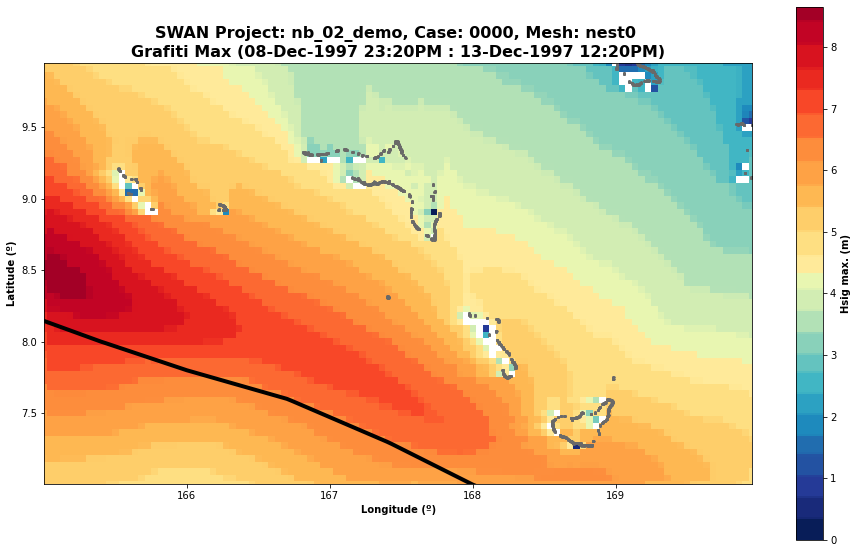

In [20]:
# Plot Hsig max - Nest mesh
plot_case_output_grafiti(sw, storm_track_list = [st], mesh=sp.mesh_nested_list[0]);


### Plot output: Control Point time series <a name="plot-ots"></a>


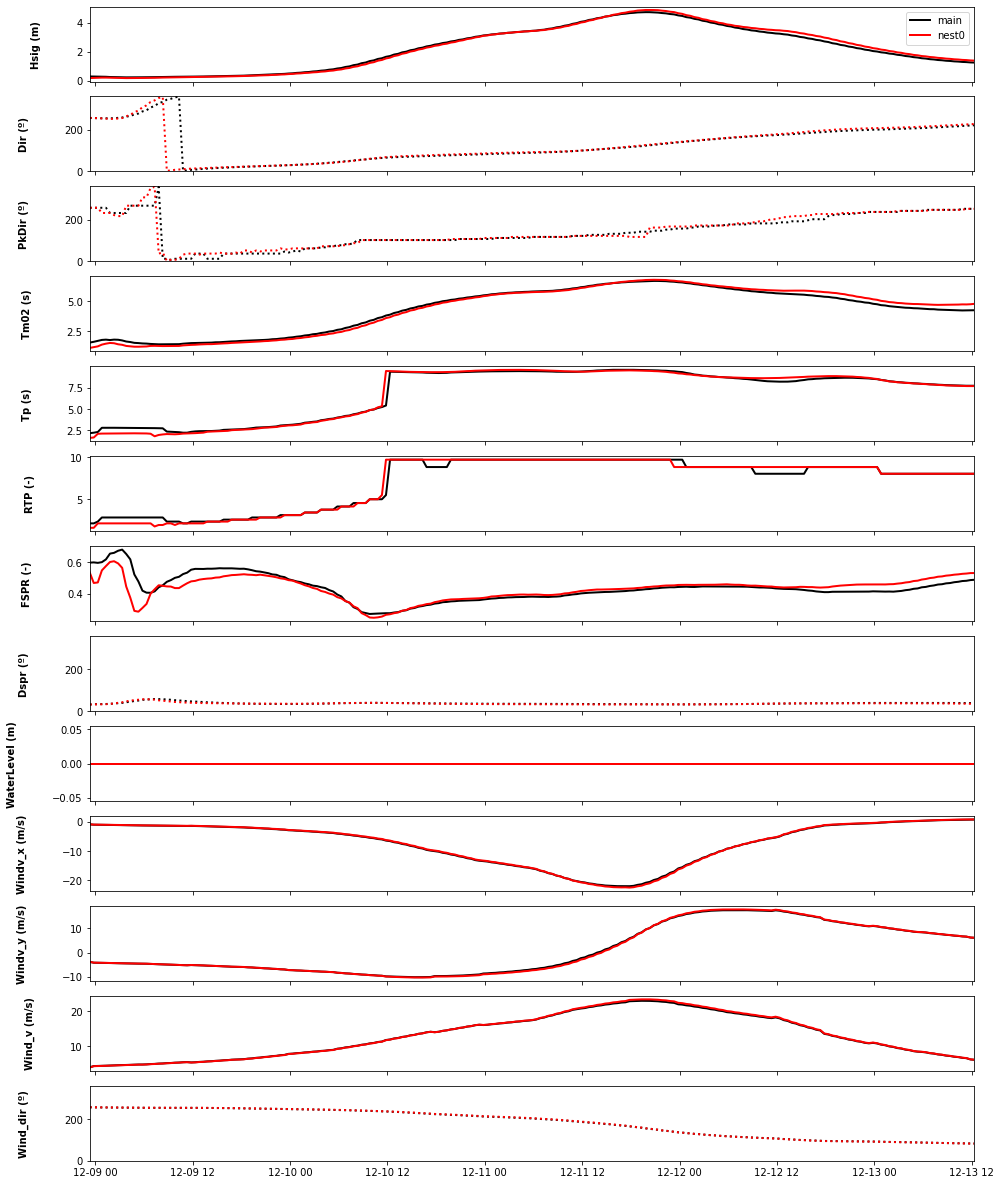

In [21]:
plot_case_output_points(sw);


###  4.3 Extract output <a name="eo"></a>


In [22]:
output_main = sw.extract_output()
print(output_main)


<xarray.Dataset>
Dimensions:     (case: 1, time: 219, lat: 95, lon: 110)
Coordinates:
  * time        (time) datetime64[ns] 1997-12-08T23:20:00 ... 1997-12-13T12:2...
  * lon         (lon) float64 160.5 160.6 160.8 160.9 ... 175.1 175.2 175.4
  * lat         (lat) float64 2.502 2.639 2.776 2.912 ... 15.09 15.22 15.36
  * case        (case) int64 0
Data variables:
    Tm02        (case, time, lat, lon) float32 nan nan nan ... 6.752 6.794 6.867
    Depth       (case, time, lat, lon) float32 3.429e+03 3.49e+03 ... 4.648e+03
    Dspr        (case, time, lat, lon) float32 nan nan nan ... 11.07 10.71 10.25
    WaterLevel  (case, time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RTpeak      (case, time, lat, lon) float32 nan nan nan ... 8.844 8.844 8.844
    FSpr        (case, time, lat, lon) float32 nan nan nan ... 0.503 0.502
    PkDir       (case, time, lat, lon) float32 nan nan nan ... 212.5 212.5 212.5
    Hsig        (case, time, lat, lon) float32 0.0 0.0 0.0 ... 0.8676 0.8623

In [23]:
output_nest = sw.extract_output(mesh=mesh_nest)
print(output_nest)


<xarray.Dataset>
Dimensions:     (case: 1, time: 219, lat: 66, lon: 110)
Coordinates:
  * time        (time) datetime64[ns] 1997-12-08T23:20:00 ... 1997-12-13T12:2...
  * lon         (lon) float64 165.0 165.0 165.1 165.1 ... 169.9 169.9 170.0
  * lat         (lat) float64 7.002 7.047 7.093 7.138 ... 9.862 9.907 9.953
  * case        (case) int64 0
Data variables:
    Tm02        (case, time, lat, lon) float32 1.219 1.226 1.23 ... 4.402 4.363
    Depth       (case, time, lat, lon) float32 5.152e+03 5.167e+03 ... 4.35e+03
    Dspr        (case, time, lat, lon) float32 31.51 31.51 31.51 ... 33.52 34.08
    WaterLevel  (case, time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RTpeak      (case, time, lat, lon) float32 1.766 1.766 1.766 ... 8.844 8.844
    FSpr        (case, time, lat, lon) float32 0.5065 0.5056 ... 0.5149 0.5069
    PkDir       (case, time, lat, lon) float32 267.5 267.5 267.5 ... 237.5 237.5
    Hsig        (case, time, lat, lon) float32 0.1262 0.1281 ... 1.049 1.

In [24]:
output_pts = sw.extract_output_points()
print(output_pts)


<xarray.Dataset>
Dimensions:     (case: 1, point: 1, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 1997-12-08T23:20:00 ... 1997-12-13T12:2...
Dimensions without coordinates: case, point
Data variables: (12/14)
    Hsig        (case, point, time) float64 0.2829 0.279 0.2744 ... 1.256 1.245
    Dir         (case, point, time) float64 256.9 256.2 255.8 ... 220.8 221.6
    PkDir       (case, point, time) float64 257.5 257.5 257.5 ... 252.5 252.5
    Tm02        (case, point, time) float64 1.571 1.635 1.711 ... 4.223 4.231
    Tp          (case, point, time) float64 2.151 2.209 2.29 ... 7.708 7.709
    RTP         (case, point, time) float64 2.134 2.134 2.347 ... 8.044 8.044
    ...          ...
    DEPTH       (case, point, time) float64 2.764e+03 2.764e+03 ... 2.764e+03
    WaterLevel  (case, point, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Windv_x     (case, point, time) float64 -0.894 -1.009 ... 0.7406 0.7471
    Windv_y     (case, point, time) float64 -3.841

In [25]:
output_pts_spec = sw.extract_output_points_spec()
print(output_pts_spec)


<xarray.Dataset>
Dimensions:    (case: 1, point: 1, frequency: 38, direction: 72, time: 219)
Coordinates:
  * frequency  (frequency) float64 0.03 0.033 0.0363 ... 0.8273 0.9096 1.0
  * direction  (direction) float64 267.5 262.5 257.5 252.5 ... -77.5 -82.5 -87.5
  * time       (time) datetime64[ns] 1997-12-08T23:20:00 ... 1997-12-13T12:20:00
Dimensions without coordinates: case, point
Data variables:
    lon_pts    (case, point) float64 167.7
    lat_pts    (case, point) float64 8.67
    spec       (case, frequency, direction, point, time) float64 0.0 0.0 ... 0.0
Attributes:
    mesh_ID:  main
